Data contains complaints about financial products are services.
This is supervised text classification problem because each complaint is labelled with a specific product for which different algorithms will be used.

Aim : Categorize the complaints 

Classification algorithms: Linear Support Vector Machine (LinearSVM), Random Forest, Multinomial Naive Bayes and Logistic Regression.

In [2]:
import os

import pandas as pd
import numpy as np
from scipy.stats import randint
import seaborn as sns # used for plot interactive graph. 
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics


In [3]:
df = pd.read_csv(r'C:\Users\kshiti.sinha\Desktop\projects\prof\rows.csv\rows.csv')
df.shape

C:\Users\kshiti.sinha\AppData\Local\Temp\ipykernel_14784\2422569120.py:1: DtypeWarning: Columns (4,5,6,11,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r'C:\Users\kshiti.sinha\Desktop\projects\prof\rows.csv\rows.csv')


(1282355, 18)

Exploratory Data Analysis and Feature Engineering

In [5]:
df.head(10).T

,0,1,2,3,4,5,6,7,8,9
Date received,05/10/2019,05/10/2019,05/10/2019,05/10/2019,05/10/2019,05/10/2019,05/10/2019,05/10/2019,05/10/2019,05/10/2019
Product,Checking or savings account,Checking or savings account,Debt collection,"Credit reporting, credit repair services, or o...",Checking or savings account,Mortgage,Debt collection,Student loan,Debt collection,"Credit reporting, credit repair services, or o..."
Sub-product,Checking account,Other banking product or service,Payday loan debt,Credit reporting,Checking account,Other type of mortgage,Other debt,Federal student loan servicing,Other debt,Credit reporting
Issue,Managing an account,Managing an account,Communication tactics,Incorrect information on your report,Managing an account,Closing on a mortgage,Attempts to collect debt not owed,Struggling to repay your loan,Attempts to collect debt not owed,Incorrect information on your report
Sub-issue,Problem using a debit or ATM card,Deposits and withdrawals,Frequent or repeated calls,Old information reappears or never goes away,Banking errors,NaN,Debt is not yours,Problem lowering your monthly payments,Debt was paid,Information belongs to someone else
Consumer complaint narrative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Company public response,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Company,NAVY FEDERAL CREDIT UNION,BOEING EMPLOYEES CREDIT UNION,CURO Intermediate Holdings,Ad Astra Recovery Services Inc,ALLY FINANCIAL INC.,Statebridge Company,"Diversified Consultants, Inc.",Student Loan Direct,"Diversified Consultants, Inc.",CONTRACT CALLERS INC
State,FL,WA,TX,LA,AZ,NJ,TX,TX,SC,MD
ZIP code,328XX,98204,751XX,708XX,85205,08302,NaN,773XX,296XX,20774


Dataset has features that is not needed for multiclass text classification so we transform with product name and consumer complaint

In [7]:
df1 = df[['Product', 'Consumer complaint narrative']].copy()

# Remove missing values (NaN)
df1 = df1[pd.notnull(df1['Consumer complaint narrative'])]

# Renaming second column for a simpler name
df1.columns = ['Product', 'complaint_consumer'] 

df1.shape

(383564, 2)

As we observe there are null values in the consumer complaints. Let us check what is percent is null values of total values

In [10]:
total = df1['complaint_consumer'].notnull().sum()
notnullval = round((total/len(df)*100),1)
null = 100 - notnullval
print(notnullval)
print(null)

29.9
70.1


this is around 380,000 out of 1 lac cases we have which we will use for further analysis
now checking unique product values 

In [11]:
pd.DataFrame(df.Product.unique()).values

array([['Checking or savings account'],
       ['Debt collection'],
       ['Credit reporting, credit repair services, or other personal consumer reports'],
       ['Mortgage'],
       ['Student loan'],
       ['Vehicle loan or lease'],
       ['Credit card or prepaid card'],
       ['Payday loan, title loan, or personal loan'],
       ['Money transfer, virtual currency, or money service'],
       ['Credit reporting'],
       ['Credit card'],
       ['Bank account or service'],
       ['Consumer Loan'],
       ['Prepaid card'],
       ['Other financial service'],
       ['Payday loan'],
       ['Money transfers'],
       ['Virtual currency']], dtype=object)

we can see there are 18 different categories here however some seem similar or repetitions of one another so we will club them and make them a single cateogory

In [13]:
# random sampling for some values to reduce computation time
df2 = df1.sample(10000, random_state=1).copy()

In [14]:
df2.replace({'Product': 
             {'Credit reporting, credit repair services, or other personal consumer reports': 
              'Credit reporting, repair, or other', 
              'Credit reporting': 'Credit reporting, repair, or other',
             'Credit card': 'Credit card or prepaid card',
             'Prepaid card': 'Credit card or prepaid card',
             'Payday loan': 'Payday loan, title loan, or personal loan',
             'Money transfer': 'Money transfer, virtual currency, or money service',
             'Virtual currency': 'Money transfer, virtual currency, or money service'}}, 
            inplace= True)

In [15]:
pd.DataFrame(df2.Product.unique())

,0
0,"Credit reporting, repair, or other"
1,Debt collection
2,Consumer Loan
3,Credit card or prepaid card
4,Mortgage
5,Vehicle loan or lease
6,Student loan
7,"Payday loan, title loan, or personal loan"
8,Checking or savings account
9,Bank account or service


In [16]:
#we give these categories numbers so that it is easier to interpret by the system 

In [17]:
# Create a new column 'category_id' with encoded categories 
df2['category_id'] = df2['Product'].factorize()[0]
category_id_df = df2[['Product', 'category_id']].drop_duplicates()


# Dictionaries for future use
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Product']].values)

# New dataframe
df2.head()

,Product,complaint_consumer,category_id
310399,"Credit reporting, repair, or other",Bayview completely ignored laws and is reporti...,0
186155,"Credit reporting, repair, or other",inaccurate information no knowledge of account...,0
651135,Debt collection,On XXXX/XXXX/2016 I received a notice from Con...,1
515233,Consumer Loan,I have a loan with Kia Motor Finance. I rece...,2
641112,Credit card or prepaid card,I have a XXXX BIG card and made my payment whe...,3


Below we see a chart of number of complaints by category and can be seen with the following reasons:

credit reporting, credit repair
debt collection
mortgage

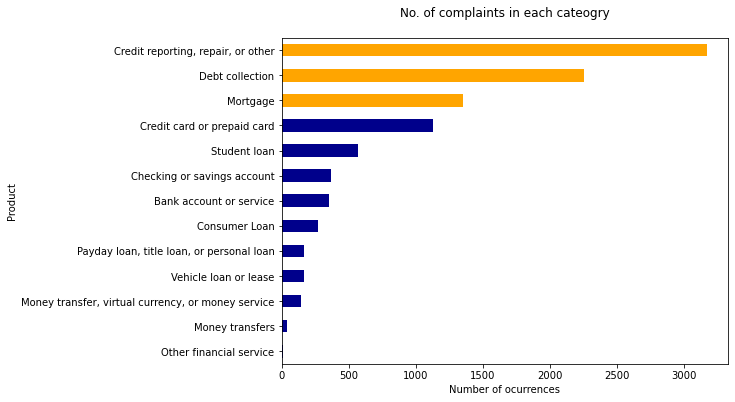

In [21]:
fig = plt.figure(figsize=(8,6))
colors = ['darkblue','darkblue','darkblue','darkblue','darkblue','darkblue','darkblue','darkblue','darkblue',
    'darkblue','orange','orange','orange']
df2.groupby('Product').complaint_consumer.count().sort_values().plot.barh(
    ylim=0, color=colors, title= 'No. of complaints in each cateogry\n')
plt.xlabel('Number of ocurrences', fontsize = 10);

The text needs to be converted to vectors in order to categorize for which we will use TF-IDF which weighs importance to the words

TfidfVectorizer class can be initialized with the following parameters:

min_df: remove the words from the vocabulary which have occurred in less than ‘min_df’ number of files.

max_df: remove the words from the vocabulary which have occurred in more than _‘maxdf’ * total number of files in corpus.

sublinear_tf: set to True to scale the term frequency in logarithmic scale.

stop_words: remove the predefined stop words in 'english'.

use_idf: weight factor must use inverse document frequency.

ngram_range: (1, 2) to indicate that unigrams and bigrams will be considered.

In [24]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

# We transform each complaint into a vector
features = tfidf.fit_transform(df2.complaint_consumer).toarray()

labels = df2.category_id

print("Each of the %d complaints is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

Each of the 10000 complaints is represented by 27507 features (TF-IDF score of unigrams and bigrams)


In [25]:
# Finding the three most correlated terms with each of the product categories
N = 3
for Product, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("\n==> %s:" %(Product))
  print("  * Most Correlated Unigrams are: %s" %(', '.join(unigrams[-N:])))
  print("  * Most Correlated Bigrams are: %s" %(', '.join(bigrams[-N:])))

C:\Users\kshiti.sinha\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



==> Bank account or service:
  * Most Correlated Unigrams are: overdraft, bank, scottrade
  * Most Correlated Bigrams are: citigold checking, debit card, checking account


C:\Users\kshiti.sinha\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



==> Checking or savings account:
  * Most Correlated Unigrams are: checking, branch, overdraft
  * Most Correlated Bigrams are: 00 bonus, overdraft fees, checking account


C:\Users\kshiti.sinha\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



==> Consumer Loan:
  * Most Correlated Unigrams are: dealership, vehicle, car
  * Most Correlated Bigrams are: car loan, vehicle loan, regional acceptance


C:\Users\kshiti.sinha\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



==> Credit card or prepaid card:
  * Most Correlated Unigrams are: express, citi, card
  * Most Correlated Bigrams are: balance transfer, american express, credit card


C:\Users\kshiti.sinha\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



==> Credit reporting, repair, or other:
  * Most Correlated Unigrams are: report, experian, equifax
  * Most Correlated Bigrams are: credit file, equifax xxxx, credit report


C:\Users\kshiti.sinha\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



==> Debt collection:
  * Most Correlated Unigrams are: collect, collection, debt
  * Most Correlated Bigrams are: debt collector, collect debt, collection agency


C:\Users\kshiti.sinha\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



==> Money transfer, virtual currency, or money service:
  * Most Correlated Unigrams are: ethereum, bitcoin, coinbase
  * Most Correlated Bigrams are: account coinbase, coinbase xxxx, coinbase account


C:\Users\kshiti.sinha\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



==> Money transfers:
  * Most Correlated Unigrams are: paypal, moneygram, gram
  * Most Correlated Bigrams are: sending money, western union, money gram


C:\Users\kshiti.sinha\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



==> Mortgage:
  * Most Correlated Unigrams are: escrow, modification, mortgage
  * Most Correlated Bigrams are: short sale, mortgage company, loan modification


C:\Users\kshiti.sinha\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



==> Other financial service:
  * Most Correlated Unigrams are: meetings, productive, vast
  * Most Correlated Bigrams are: insurance check, check payable, face face


C:\Users\kshiti.sinha\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



==> Payday loan, title loan, or personal loan:
  * Most Correlated Unigrams are: astra, ace, payday
  * Most Correlated Bigrams are: 00 loan, applied payday, payday loan


C:\Users\kshiti.sinha\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



==> Student loan:
  * Most Correlated Unigrams are: student, loans, navient
  * Most Correlated Bigrams are: income based, student loan, student loans

==> Vehicle loan or lease:
  * Most Correlated Unigrams are: honda, car, vehicle
  * Most Correlated Bigrams are: used vehicle, total loss, honda financial


C:\Users\kshiti.sinha\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Multi-Classification models

The classification models evaluated are:

Random Forest,
Linear Support Vector Machine,
Multinomial Naive Bayes,
Logistic Regression.

In [27]:
#x is the train set features and y is the target set feature
X = df2['complaint_consumer'] # Collection of documents
y = df2['Product'] # Target or the labels we want to predict (i.e., the 13 different complaints of products)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 0)

In [29]:
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

C:\Users\kshiti.sinha\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\kshiti.sinha\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

In [30]:
#Comparison of Model Performance

mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

,Mean Accuracy,Standard deviation
model_name,,
LinearSVC,0.7791,0.005561
LogisticRegression,0.7641,0.009839
MultinomialNB,0.6475,0.004596
RandomForestClassifier,0.3949,0.006665


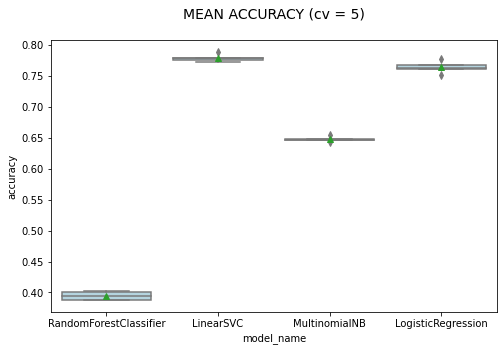

In [31]:
plt.figure(figsize=(8,5))
sns.boxplot(x='model_name', y='accuracy', 
            data=cv_df, 
            color='lightblue', 
            showmeans=True)
plt.title("MEAN ACCURACY (cv = 5)\n", size=14);

In [32]:
#Model Evaluation

X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(features, 
                                                               labels, 
                                                               df2.index, test_size=0.25, 
                                                               random_state=1)
model = LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [33]:
# Precision, Recall, F1-score
# Classification report

print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(y_test, y_pred, 
                                    target_names= df2['Product'].unique()))

				CLASSIFICATIION METRICS

                                                    precision    recall  f1-score   support

                Credit reporting, repair, or other       0.81      0.88      0.84       783
                                   Debt collection       0.76      0.80      0.78       588
                                     Consumer Loan       0.52      0.22      0.31        73
                       Credit card or prepaid card       0.73      0.82      0.77       253
                                          Mortgage       0.87      0.92      0.90       340
                             Vehicle loan or lease       0.43      0.14      0.21        43
                                      Student loan       0.85      0.85      0.85       155
         Payday loan, title loan, or personal loan       0.50      0.17      0.26        40
                       Checking or savings account       0.61      0.60      0.61        85
                           Bank account or service

C:\Users\kshiti.sinha\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kshiti.sinha\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kshiti.sinha\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


It is possible to observe that the classes with more support (number of occurrences) tend to have a better f1-cscore. This is because the algorithm was trained with more data.

The classes that can be classified with more precision are ‘Mortgage’, ‘Credit reporting, repair, or other’, and ‘Student loan’.


A Confusion Matrix is a table which rows represent the actual class and columns represents the predicted class.

If we had a perfect model that always classifies correctly a new complaint, then the confusion matrix would have values in the diagonal only (where predicted label = actual label).

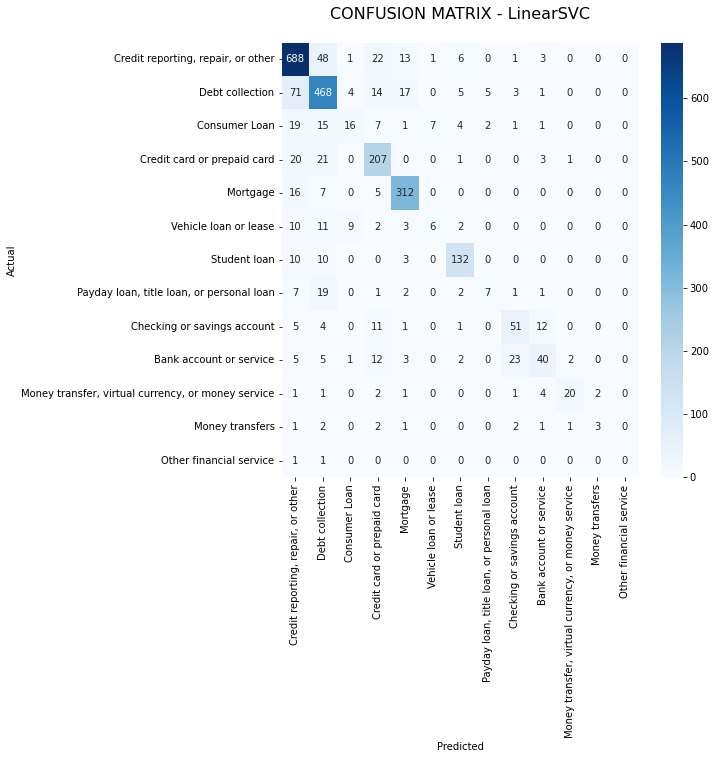

In [34]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=category_id_df.Product.values, 
            yticklabels=category_id_df.Product.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LinearSVC\n", size=16);

In [36]:
#Misclassified complaints

for predicted in category_id_df.category_id:
  for actual in category_id_df.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 20:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], 
                                                           id_to_category[predicted], 
                                                           conf_mat[actual, predicted]))
    
      display(df2.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['Product', 
                                                                'complaint_consumer']])
      print('')

'Debt collection' predicted as 'Credit reporting, repair, or other' : 71 examples.


,Product,complaint_consumer
483075,Debt collection,This agency has three collections listed which...
111807,Debt collection,I am writing to dispute the inaccurate data be...
376788,Debt collection,check n ' Go payday loan made me a loan and th...
570764,Debt collection,THIS AMT OWED {$8800.00} WAS TO BE PAID UNDER ...
88089,Debt collection,I am submitting this complaint for an account ...
...,...,...
155139,Debt collection,"Between XX/XX/XXXX and XX/XX/XXXX, this accoun..."
360018,Debt collection,"On XXXX XXXX, 2017 XXXX opened up an account f..."
165296,Debt collection,I have tried disputing with the bureau on seve...
159609,Debt collection,This is a complaint against National Credit Sy...



'Credit card or prepaid card' predicted as 'Credit reporting, repair, or other' : 20 examples.


,Product,complaint_consumer
399397,Credit card or prepaid card,"On XXXX XXXX, XXXX I submitted correspondence ..."
752303,Credit card or prepaid card,I purchased a room size air conditioner from X...
544109,Credit card or prepaid card,To Whom May Concern : Early Spring XX/XX/XXXX ...
723669,Credit card or prepaid card,The Sychrony issued excessive credit to me thr...
202661,Credit card or prepaid card,I reviewed my credit report and saw an account...
891797,Credit card or prepaid card,I have a SYNCB/WALMART DUAL CARD. Unbeknownst ...
280866,Credit card or prepaid card,XX/XX/2017 Monthly payment XXXX dollars. I rea...
350390,Credit card or prepaid card,I received a letter from XXXX On XXXX XXXX 201...
413596,Credit card or prepaid card,"XXXX investigated the following listing, XXXX ..."
725609,Credit card or prepaid card,Seventh Ave has charged off an account and con...



'Credit reporting, repair, or other' predicted as 'Debt collection' : 48 examples.


,Product,complaint_consumer
167717,"Credit reporting, repair, or other",When my vehicle was repossessed in XX/XX/2017 ...
131925,"Credit reporting, repair, or other",I submitted a dispute online on a debt with XX...
675868,"Credit reporting, repair, or other",My name is XXXX XXXX. Your collection agency i...
370575,"Credit reporting, repair, or other",Credit reporting agency incorrectly keeps repo...
863037,"Credit reporting, repair, or other",This medical bill was paid to another collecto...
597294,"Credit reporting, repair, or other","I received a call, and my oldest daughter got ..."
301509,"Credit reporting, repair, or other",While attempting to get approval for a loan to...
404336,"Credit reporting, repair, or other",On XX/XX/XXXX I sent a letter to Wakefield & A...
310415,"Credit reporting, repair, or other","Portfolio Recov Assoc, Promise to remove the c..."
347164,"Credit reporting, repair, or other",XXXX Inquired because someone is trying to use...



'Credit card or prepaid card' predicted as 'Debt collection' : 21 examples.


,Product,complaint_consumer
427835,Credit card or prepaid card,XXXX would not honor an offer to credit {$50.0...
468331,Credit card or prepaid card,hi I 'm on payment program with American expre...
36821,Credit card or prepaid card,"I am corresponding about my XXXX XXXX XXXX, wh..."
681770,Credit card or prepaid card,I sent the following message to Capital One on...
859065,Credit card or prepaid card,I had several attempts to get information abou...
504540,Credit card or prepaid card,This is in regards to BOTH a Total Visa acco...
872562,Credit card or prepaid card,I used a debt relief agency to pay my debts ( ...
609682,Credit card or prepaid card,I have a letter stating from American Express ...
907179,Credit card or prepaid card,I keep getting a robo call ( XXXX ) threatenin...
517845,Credit card or prepaid card,Bank of America is refusing to produce proof o...



'Credit reporting, repair, or other' predicted as 'Credit card or prepaid card' : 22 examples.


,Product,complaint_consumer
184965,"Credit reporting, repair, or other",XXXX is a company of XXXX and XXXX XXXX up my...
846410,"Credit reporting, repair, or other",There is incorrect credit card showing up on m...
192020,"Credit reporting, repair, or other",I went to the Capital One web site to apply fo...
265650,"Credit reporting, repair, or other",XXXX XXXX XXXX reported my account as charged ...
301997,"Credit reporting, repair, or other","XXXX Barclay , XXXX and XXXX are not updating ..."
473355,"Credit reporting, repair, or other",Company : USAA Summary of events : About XXXX ...
257154,"Credit reporting, repair, or other",I had an automatic payment of {$50.00} schedul...
168845,"Credit reporting, repair, or other",It percieved XXXX and other credit reporting a...
421206,"Credit reporting, repair, or other",Unable to get by bots or reach by telephone. C...
49300,"Credit reporting, repair, or other",In XX/XX/XXXX I needed a credit card to use to...



'Bank account or service' predicted as 'Checking or savings account' : 23 examples.


,Product,complaint_consumer
655179,Bank account or service,My email is XXXXXXXXXXXX and I never got to pr...
540543,Bank account or service,HSBC refuses to confirm the date my account wa...
655963,Bank account or service,Bank of America has charged me numerous XXXX f...
593920,Bank account or service,My complaint is with Capital One 360 ; they do...
692350,Bank account or service,"My name is XXXX, I am my father 's heir & the ..."
760899,Bank account or service,I have a XXXX IRA with Capital One 360. My mob...
674009,Bank account or service,"On XXXX XXXX 2016, I 'd visited the Wells Farg..."
541558,Bank account or service,On XXXX my husband deposited {$400.00} through...
547387,Bank account or service,"On XX/XX/XXXX, a merchant presented an electro..."
816633,Bank account or service,On XXXX I deposited an insurance claim check (...


In [37]:
#most correlated terms with each other

model.fit(features, labels)

N = 4
for Product, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("\n==> '{}':".format(Product))
  print("  * Top unigrams: %s" %(', '.join(unigrams)))
  print("  * Top bigrams: %s" %(', '.join(bigrams)))

C:\Users\kshiti.sinha\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



==> 'Bank account or service':
  * Top unigrams: bank, scottrade, deposit, suntrust
  * Top bigrams: bank xxxx, check account, debit card, xx 2016

==> 'Checking or savings account':
  * Top unigrams: bank, transactions, bonus, branch
  * Top bigrams: debit card, xxxx 2017, overdraft fees, account information

==> 'Consumer Loan':
  * Top unigrams: car, furniture, title, loan
  * Top bigrams: vehicle loan, lien release, regional acceptance, xxxx constantly

==> 'Credit card or prepaid card':
  * Top unigrams: card, capital, citi, amex
  * Top bigrams: american express, use card, balance transfer, annual fee

==> 'Credit reporting, repair, or other':
  * Top unigrams: equifax, experian, transunion, report
  * Top bigrams: xxxx reported, equifax xxxx, xxxx xxxx, trans union

==> 'Debt collection':
  * Top unigrams: debt, collection, collections, owe
  * Top bigrams: credit services, trying collect, violation knowledge, account credit

==> 'Money transfer, virtual currency, or money serv

In [38]:
#PREDICTIONS

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 0)

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

fitted_vectorizer = tfidf.fit(X_train)
tfidf_vectorizer_vectors = fitted_vectorizer.transform(X_train)

model = LinearSVC().fit(tfidf_vectorizer_vectors, y_train)

In [39]:
#classifying new data according to the model

new_complaint = """I have been enrolled back at XXXX XXXX University in the XX/XX/XXXX. Recently, i have been harassed by \
Navient for the last month. I have faxed in paperwork providing them with everything they needed. And yet I am still getting \
phone calls for payments. Furthermore, Navient is now reporting to the credit bureaus that I am late. At this point, \
Navient needs to get their act together to avoid me taking further action. I have been enrolled the entire time and my \
deferment should be valid with my planned graduation date being the XX/XX/XXXX."""
print(model.predict(fitted_vectorizer.transform([new_complaint])))

['Student loan']


In [41]:
#complaint tag

df2[df2['complaint_consumer'] == new_complaint]

,Product,complaint_consumer,category_id
877489,Student loan,I have been enrolled back at XXXX XXXX Univers...,6


In [42]:
new_complaint_2 = """Equifax exposed my personal information without my consent, as part of their recent data breach. \
In addition, they dragged their feet in the announcement of the report, and even allowed their upper management to sell \
off stock before the announcement."""
print(model.predict(fitted_vectorizer.transform([new_complaint_2])))

['Credit reporting, repair, or other']


In [43]:
df2[df2['complaint_consumer'] == new_complaint_2]

,Product,complaint_consumer,category_id
420821,"Credit reporting, repair, or other",Equifax exposed my personal information withou...,0
